# Bias Feature Cluster Visualization (UMAP)

This notebook visualizes the distribution of bias-related features in a 2D space using UMAP dimensionality reduction.

**Purpose:**
- Visualize how bias features cluster in the SAE latent space
- Compare feature distributions across 9 demographic dimensions
- Identify shared vs. unique bias features

**Input Data:**
- SAE decoder weights: [100,000 × 4,096]
- IG² attribution results: top-k features per demographic

**Output:**
- 3×3 grid of UMAP scatter plots
- Feature frequency histogram

In [1]:
import os
import sys
import warnings
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
PROJECT_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJECT_ROOT))

from src.visualization import (
    setup_korean_font,
    load_demographics,
    load_ig2_results,
    load_sae_decoder_weights,
    prepare_umap_data,
    plot_umap_clusters,
    plot_feature_frequency_histogram,
    get_demographic_labels
)

warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier


## Configuration

In [2]:
# Setup Korean font for matplotlib
setup_korean_font()

# Seaborn style
sns.set_style('whitegrid')
sns.set_context('paper')

Font configured: ['Noto Sans CJK KR']


In [3]:
# Paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage: 'pilot', 'medium', or 'full'
STAGE = "pilot"

# SAE configuration
SAE_TYPE = "gated"  # 'standard' or 'gated'
LAYER_QUANTILE = "q2"  # 'q1', 'q2', or 'q3'

# Visualization parameters
TOP_K = 100  # Number of top features per demographic

print(f"Data stage: {STAGE}")
print(f"SAE type: {SAE_TYPE}")
print(f"Layer quantile: {LAYER_QUANTILE}")
print(f"Top-k features: {TOP_K}")

Data stage: pilot
SAE type: gated
Layer quantile: q2
Top-k features: 100


## Load Data

In [4]:
# Load demographics
demographics_dict = load_demographics(DATA_DIR)
demographic_labels_ko, demographic_labels_en = get_demographic_labels(demographics_dict)

print(f"Demographics: {len(demographic_labels_ko)}")
for ko, en in zip(demographic_labels_ko, demographic_labels_en):
    print(f"  - {ko} ({en})")

Demographics: 9
  - 성별 (gender)
  - 인종 (ethnicity)
  - 종교 (religion)
  - 성적지향 (sexuality)
  - 나이 (age)
  - 외모 (physical appearance)
  - 경제수준 (socioeconomic status)
  - 정치성향 (politics)
  - 직업 (occupation)


In [5]:
# Load IG² results (loads from all per-demographic directories)
ig2_results = load_ig2_results(RESULTS_DIR, stage=STAGE)

print(f"\nIG² results loaded for {len(ig2_results)} demographics")
for demo, data in ig2_results.items():
    if isinstance(data, dict) and 'feature_scores' in data:
        scores = data['feature_scores']
    else:
        scores = data
    print(f"  - {demo}: {len(scores) if hasattr(scores, '__len__') else 'N/A'} features")


IG² results loaded for 9 demographics
  - 외모: 100000 features
  - 성적지향: 100000 features
  - 정치성향: 100000 features
  - 직업: 100000 features
  - 종교: 100000 features
  - 경제수준: 100000 features
  - 성별: 100000 features
  - 인종: 100000 features
  - 나이: 100000 features


In [6]:
# Load SAE decoder weights (from results/models/sae-{type}_{stage}_{layer}/)
decoder_weights = load_sae_decoder_weights(
    RESULTS_DIR, 
    stage=STAGE,
    sae_type=SAE_TYPE,
    layer_quantile=LAYER_QUANTILE
)

print(f"\nDecoder weights shape: {decoder_weights.shape}")
print(f"  Features: {decoder_weights.shape[0]:,}")
print(f"  Latent dim: {decoder_weights.shape[1]:,}")


Decoder weights shape: torch.Size([100000, 4096])
  Features: 100,000
  Latent dim: 4,096


## Apply UMAP Dimensionality Reduction

In [7]:
# Prepare UMAP data
embeddings, all_features, demographic2topfeatures = prepare_umap_data(
    decoder_weights=decoder_weights,
    ig2_results=ig2_results,
    top_k=TOP_K
)

print(f"\nUMAP embeddings shape: {embeddings.shape}")
print(f"Total unique features selected: {len(all_features)}")
print(f"\nTop features per demographic:")
for demo, features in demographic2topfeatures.items():
    print(f"  - {demo}: {len(features)} features")

Total features selected: 375
Features per demographic: 100

UMAP embeddings shape: (375, 2)
Total unique features selected: 375

Top features per demographic:
  - 외모: 100 features
  - 성적지향: 100 features
  - 정치성향: 100 features
  - 직업: 100 features
  - 종교: 100 features
  - 경제수준: 100 features
  - 성별: 100 features
  - 인종: 100 features
  - 나이: 100 features


## Visualize Feature Clusters

Saved to /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets/umap_bias_features_pilot_top100.png


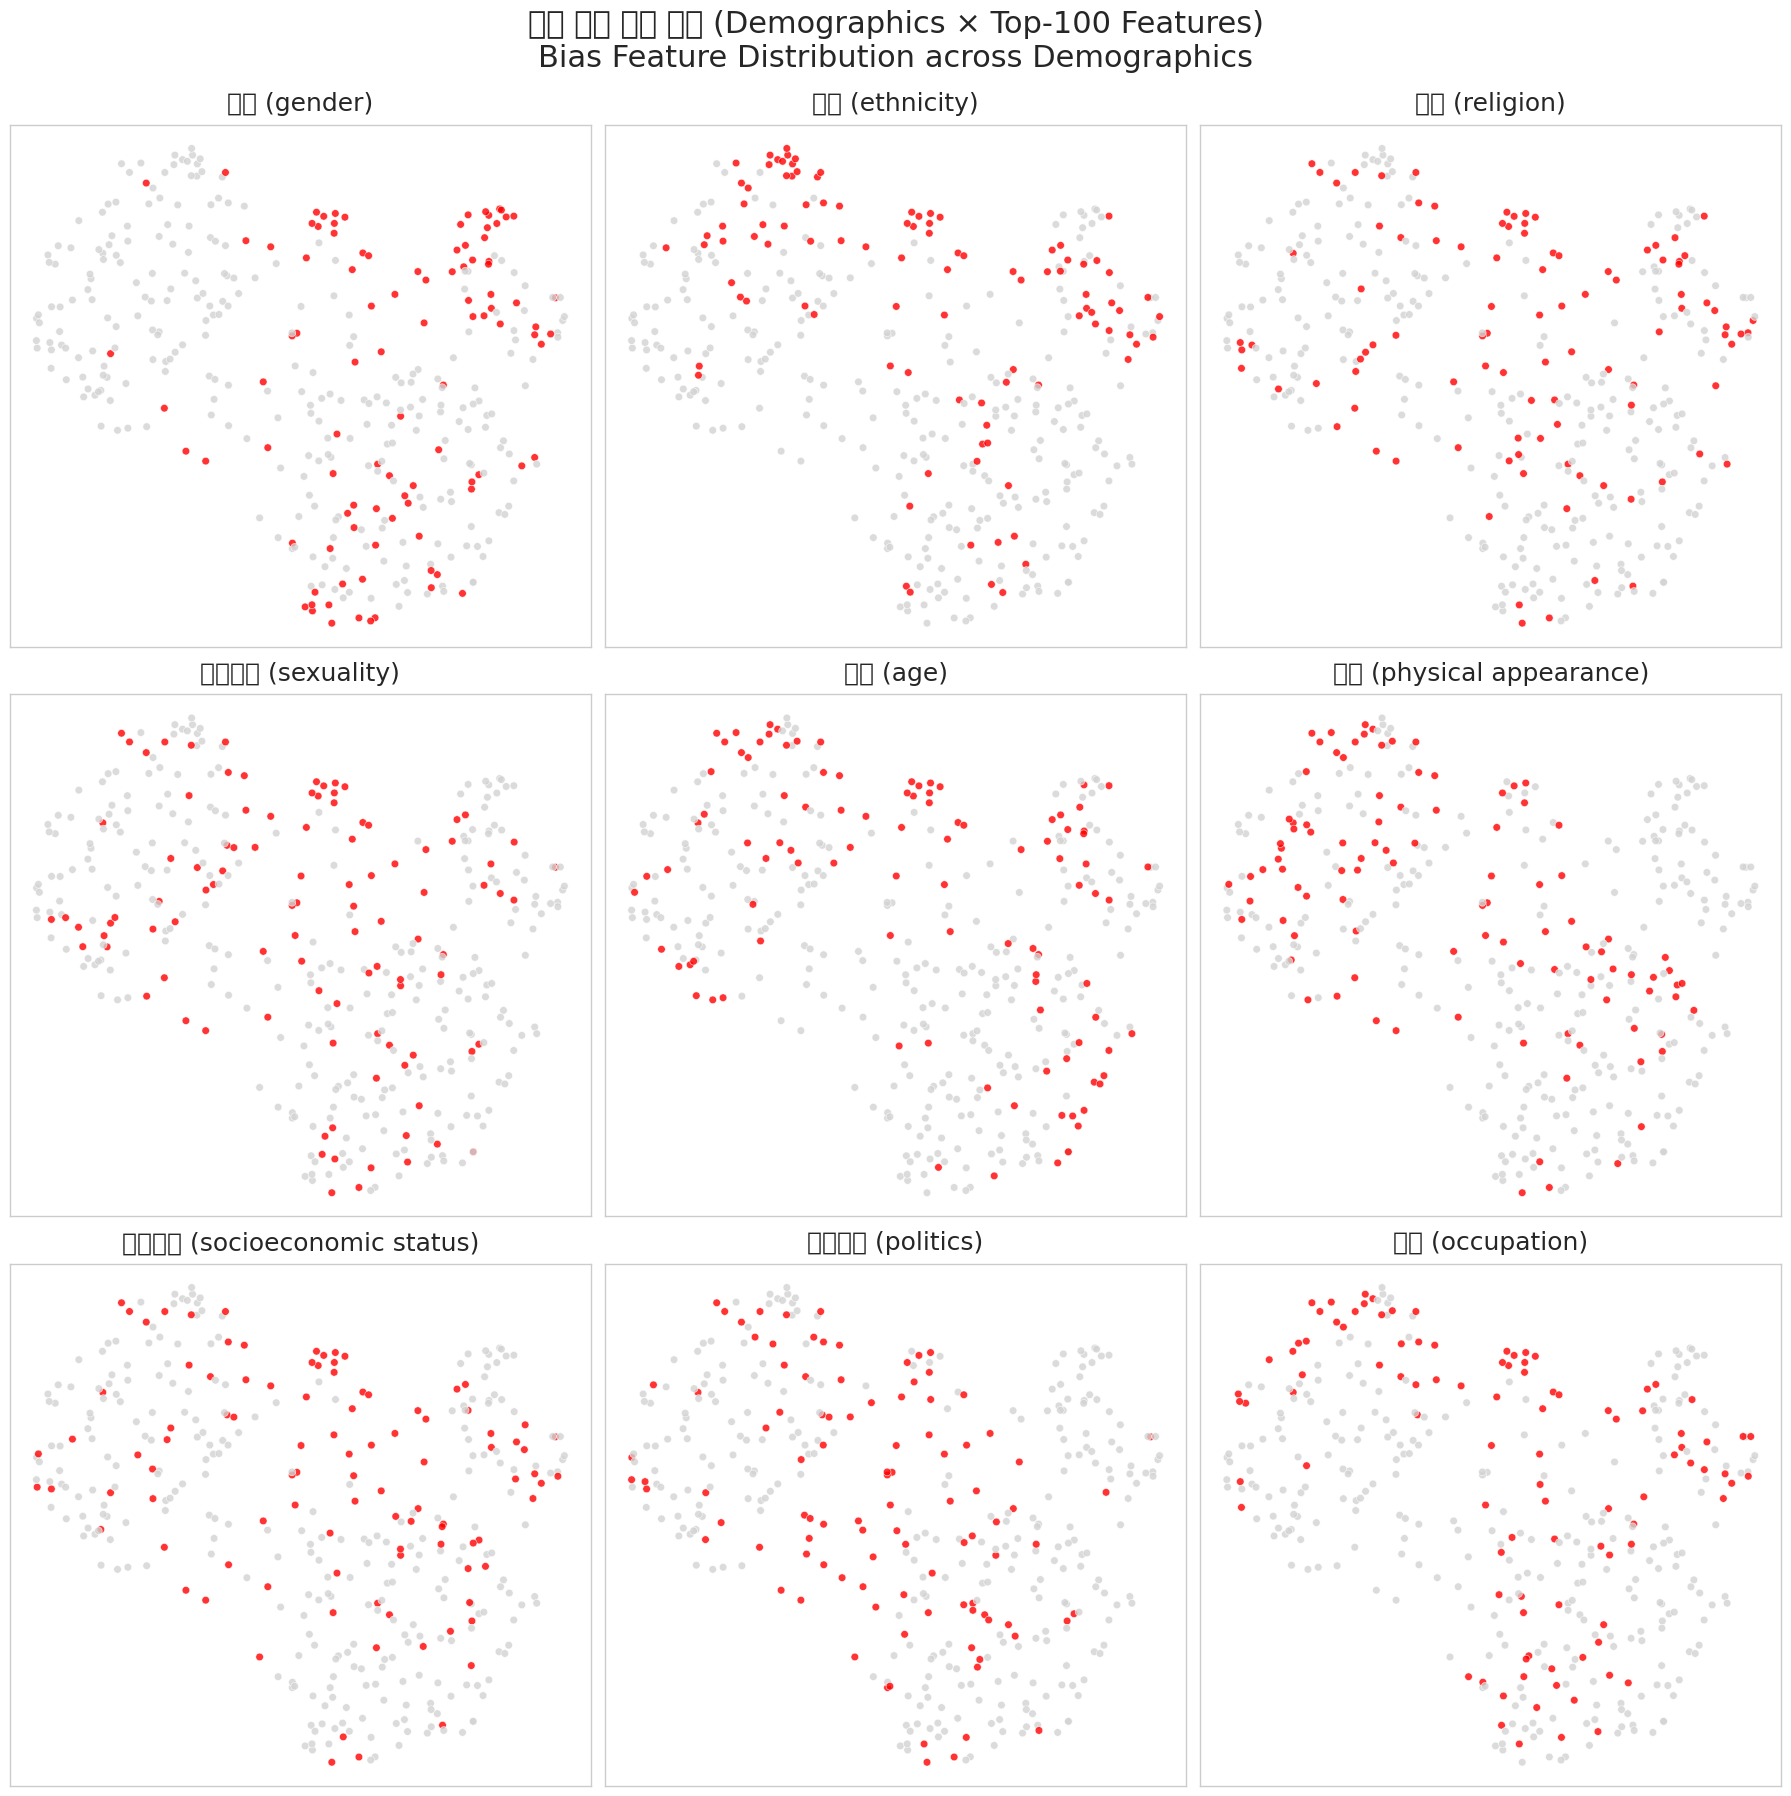

In [8]:
# Plot UMAP clusters
fig = plot_umap_clusters(
    embeddings=embeddings,
    all_features=all_features,
    demographic2topfeatures=demographic2topfeatures,
    demographic_labels_ko=demographic_labels_ko,
    demographic_labels_en=demographic_labels_en,
    save_path=ASSETS_DIR / f"umap_bias_features_{STAGE}_top{TOP_K}.png",
    figsize=(18, 18),
    top_k=TOP_K
)

plt.show()

## Feature Frequency Analysis

Saved to /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets/feature_frequency_pilot_top100.png


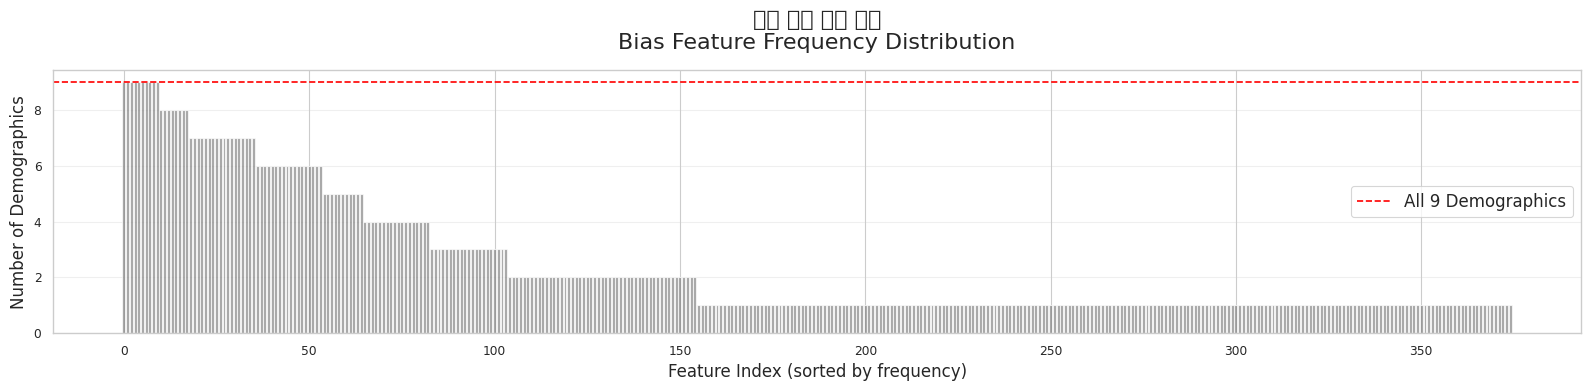

In [9]:
# Plot feature frequency histogram
fig = plot_feature_frequency_histogram(
    demographic2topfeatures=demographic2topfeatures,
    save_path=ASSETS_DIR / f"feature_frequency_{STAGE}_top{TOP_K}.png",
    figsize=(16, 4)
)

plt.show()

## Feature Overlap Analysis

In [10]:
from src.visualization.umap_utils import compute_feature_overlap, get_feature_frequency

# Compute pairwise overlaps
overlaps = compute_feature_overlap(demographic2topfeatures)

print("\nPairwise Feature Overlaps:")
print("=" * 60)
for (demo1, demo2), overlap in sorted(overlaps.items(), key=lambda x: -x[1])[:10]:
    print(f"{demo1:15s} ↔ {demo2:15s}: {overlap:3d} shared features")

# Feature frequency
feature_freq = get_feature_frequency(demographic2topfeatures)

print(f"\n\nFeature Frequency Statistics:")
print("=" * 60)
freq_counts = {}
for freq in feature_freq.values():
    freq_counts[freq] = freq_counts.get(freq, 0) + 1

for freq in sorted(freq_counts.keys(), reverse=True):
    count = freq_counts[freq]
    print(f"Features appearing in {freq} demographics: {count}")


Pairwise Feature Overlaps:
성적지향            ↔ 경제수준           :  64 shared features
종교              ↔ 경제수준           :  62 shared features
성적지향            ↔ 정치성향           :  57 shared features
성적지향            ↔ 종교             :  57 shared features
직업              ↔ 인종             :  56 shared features
외모              ↔ 경제수준           :  54 shared features
정치성향            ↔ 경제수준           :  53 shared features
종교              ↔ 성별             :  53 shared features
성적지향            ↔ 성별             :  52 shared features
직업              ↔ 나이             :  50 shared features


Feature Frequency Statistics:
Features appearing in 9 demographics: 10
Features appearing in 8 demographics: 8
Features appearing in 7 demographics: 18
Features appearing in 6 demographics: 18
Features appearing in 5 demographics: 11
Features appearing in 4 demographics: 18
Features appearing in 3 demographics: 21
Features appearing in 2 demographics: 51
Features appearing in 1 demographics: 220


## Summary Statistics

In [11]:
from src.visualization.feature_selection import get_shared_features, get_unique_features

# Shared features (appear in multiple demographics)
shared_features = get_shared_features(demographic2topfeatures, min_demographics=2)
print(f"\nShared features (≥2 demographics): {len(shared_features)}")

highly_shared = get_shared_features(demographic2topfeatures, min_demographics=5)
print(f"Highly shared features (≥5 demographics): {len(highly_shared)}")

# Unique features per demographic
unique_features = get_unique_features(demographic2topfeatures)
print(f"\nUnique features per demographic:")
for demo, features in unique_features.items():
    print(f"  - {demo}: {len(features)} unique features")


Shared features (≥2 demographics): 155
Highly shared features (≥5 demographics): 65

Unique features per demographic:
  - 외모: 27 unique features
  - 성적지향: 16 unique features
  - 정치성향: 33 unique features
  - 직업: 25 unique features
  - 종교: 20 unique features
  - 경제수준: 11 unique features
  - 성별: 27 unique features
  - 인종: 32 unique features
  - 나이: 29 unique features


## Interpretation

### What to Look For:

1. **Clustering Patterns:**
   - Do bias features for a demographic cluster together?
   - Are there distinct regions for different demographics?
   - Do some demographics share feature clusters?

2. **Feature Overlap:**
   - Which demographics have the most shared features?
   - Are there "universal" bias features appearing across many demographics?
   - Which demographics have mostly unique features?

3. **Spatial Distribution:**
   - Are positive/negative bias features separated?
   - Do related demographics (e.g., gender, sexuality) have nearby clusters?
   - Are there outlier features far from the main clusters?

### Next Steps:

1. Examine IG² rankings for top features
2. Analyze activation patterns across prompts
3. Test suppression/amplification effects
4. Investigate specific high-frequency features